In [1]:
%reload_ext autoreload
%autoreload 2

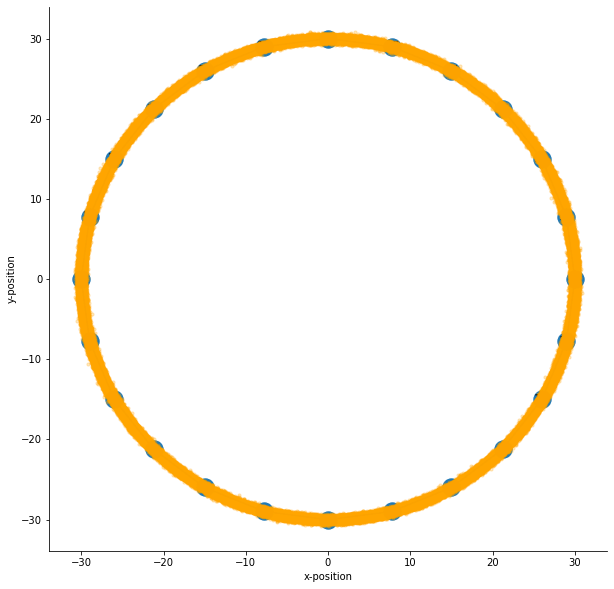

In [2]:
from track_linearization import make_track_graph, plot_track_graph
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

angle = np.linspace(-np.pi, np.pi, num=24, endpoint=False)
radius = 30

node_positions = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

node_ids = np.arange(node_positions.shape[0])
edges = np.stack((node_ids, np.roll(node_ids, shift=1)), axis=1)

track_graph = make_track_graph(node_positions, edges)

position_angles = np.linspace(-np.pi, 31 * np.pi, num=360_000, endpoint=False)
position = np.stack((radius * np.cos(position_angles), radius * np.sin(position_angles)), axis=1)
position += multivariate_normal(mean=0, cov=.05).rvs(position.shape)

fig, ax = plt.subplots(figsize=(10, 10))
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.scatter(position[:, 0], position[:, 1], alpha=0.25, s=10, zorder=11, color="orange")

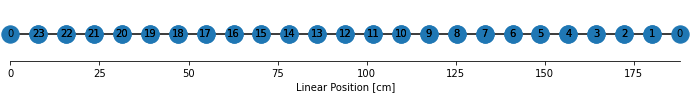

In [3]:
from track_linearization import plot_graph_as_1D

edge_spacing = 0
n_nodes = len(track_graph.nodes)
edge_order = np.stack((np.roll(np.arange(n_nodes-1, -1, -1), 1),
                       np.arange(n_nodes-1, -1, -1)), axis=1)

fig, ax = plt.subplots(figsize=(n_nodes // 2, 1))
plot_graph_as_1D(track_graph,
                 edge_spacing=edge_spacing,
                 edge_order=edge_order,
                 ax=ax)

In [4]:
from track_linearization import get_linearized_position

position_df = get_linearized_position(position, track_graph, edge_order=edge_order, edge_spacing=edge_spacing, use_HMM=False)
position_df

,linear_position,track_segment_id,projected_x_position,projected_y_position
0,0.264168,0,-29.965519,0.261908
1,187.617627,1,-29.955609,-0.337180
2,187.427465,1,-29.930788,-0.525715
3,0.042814,0,-29.994412,0.042448
4,187.849037,1,-29.985814,-0.107750
...,...,...,...,...
359995,0.172680,0,-29.977461,0.171203
359996,0.256594,0,-29.966508,0.254399
359997,187.933728,1,-29.996869,-0.023783
359998,187.745126,1,-29.972251,-0.210772


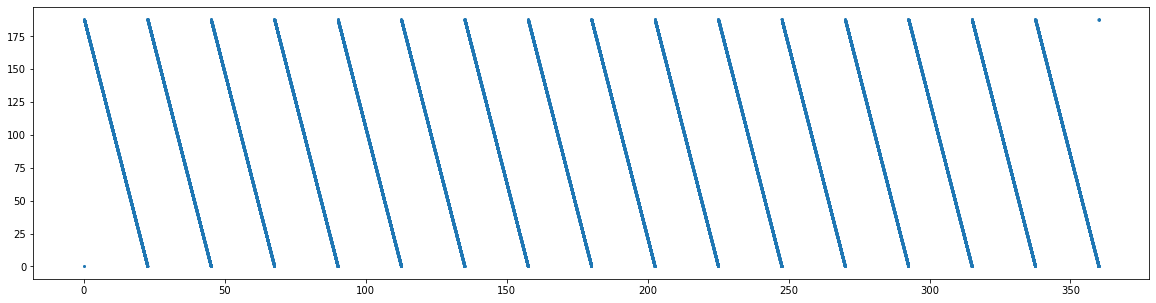

In [5]:
plt.figure(figsize=(20, 5))

sampling_frequency = 1000
time = np.arange(position_df.linear_position.size) / sampling_frequency
plt.scatter(time, position_df.linear_position, clip_on=False, s=1)

In [6]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field

angle = np.linspace(-np.pi, np.pi, num=24, endpoint=False)

place_field_centers = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

spikes = np.stack([simulate_neuron_with_place_field(center, position, sampling_frequency=sampling_frequency, variance=6.0**2)
                   for center in place_field_centers], axis=1)
spikes.shape

(360000, 24)

In [7]:
spikes.sum(axis=0)

array([420., 450., 421., 431., 444., 430., 424., 458., 440., 451., 390.,
       461., 444., 432., 444., 400., 424., 438., 437., 447., 431., 442.,
       426., 444.])

(-33.643697910559034,
 33.67337237400131,
 -33.57039619719884,
 33.746674087361505)

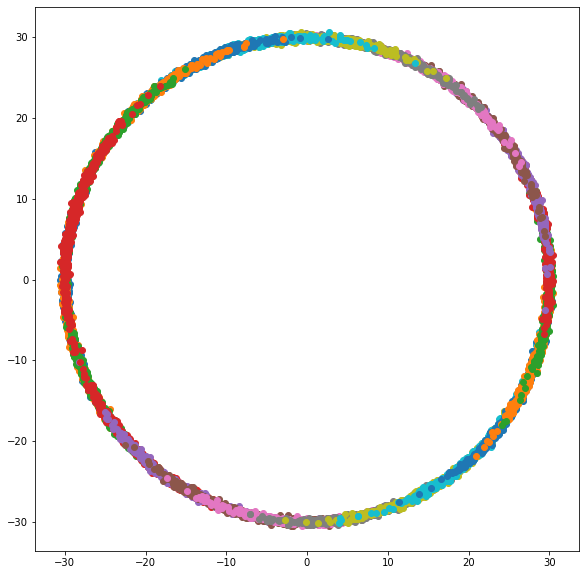

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
for spike in spikes.T:
    spike_ind = np.nonzero(spike)[0]
    ax.scatter(position[spike_ind, 0], position[spike_ind, 1])
    
ax.axis("square")

In [9]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(position, sampling_frequency)
movement_var = np.mean(np.diag(movement_var))
place_bin_size = 1.0

decoder = SortedSpikesDecoder(
    replay_speed=1,
    movement_var=movement_var,
    place_bin_size=place_bin_size)

decoder

SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=99.77883069110007, place_bin_size=1.0,
                    position_range=None, replay_speed=1,
                    spike_model_penalty=10.0, transition_type='random_walk')

In [10]:
decoder.fit(position_df.linear_position,
            spikes,
            track_graph=track_graph,
            edge_order=edge_order,
            edge_spacing=edge_spacing)

SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=99.77883069110007, place_bin_size=1.0,
                    position_range=None, replay_speed=1,
                    spike_model_penalty=10.0, transition_type='random_walk')

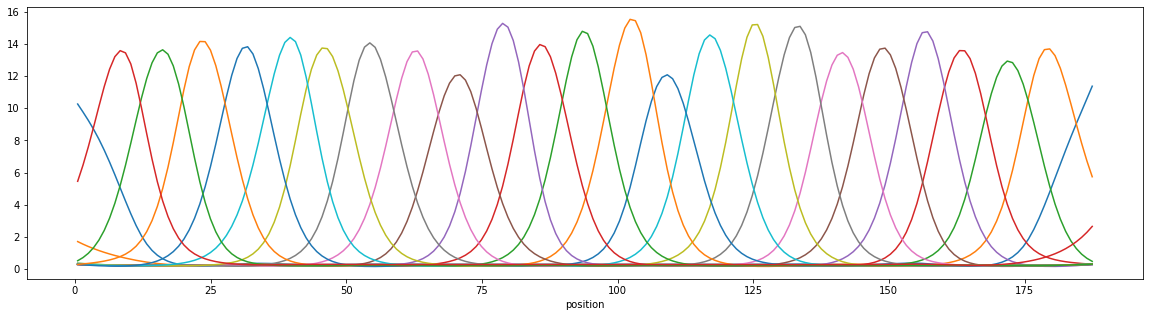

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))
(decoder.place_fields_ * sampling_frequency).plot(x="position", hue="neuron", add_legend=False, ax=ax);

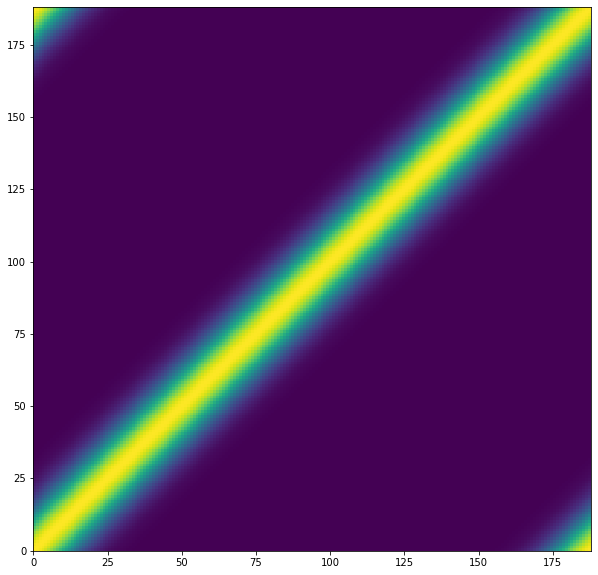

In [12]:
plt.figure(figsize=(10, 10))
bin1, bin2 = np.meshgrid(decoder.place_bin_edges_, decoder.place_bin_edges_)
plt.pcolormesh(bin1, bin2, decoder.state_transition_.T, vmin=0.0)

In [13]:
results = decoder.predict(spikes, time=time)

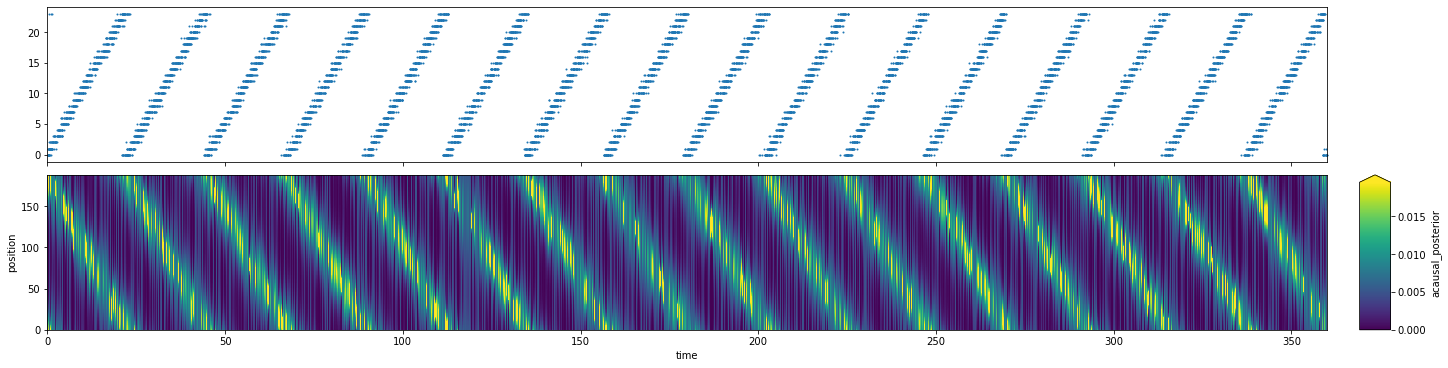

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True, constrained_layout=True)

spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[0].scatter(time[spike_time_ind], neuron_ind, clip_on=False, s=1)

results.acausal_posterior.plot(x="time", y="position", vmin=0.0, ax=axes[1], robust=True)
# axes[1].scatter(time, position_df.linear_position, color="magenta", s=1)

In [15]:
spike_time_ind

array([    63,     65,    139, ..., 359817, 359856, 359885])

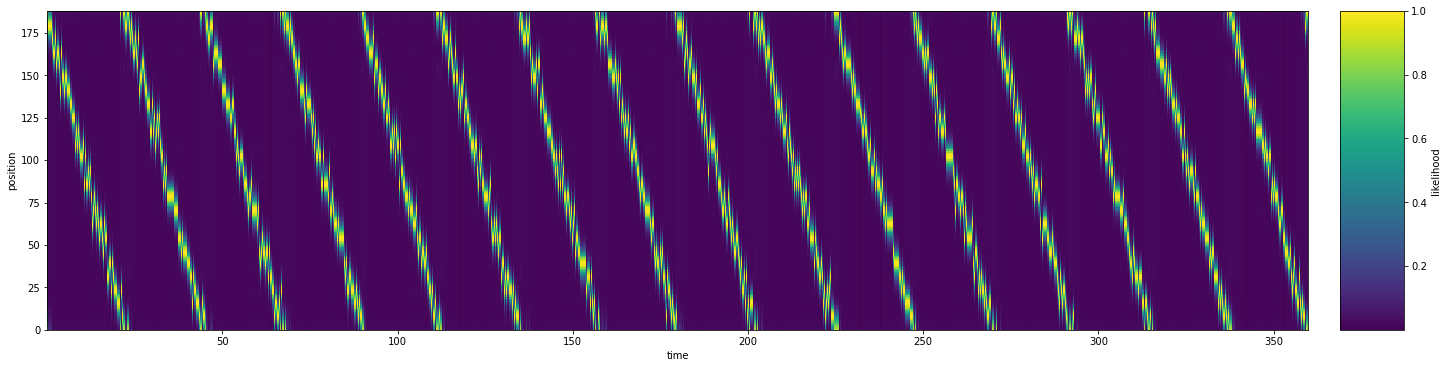

In [16]:
plt.subplots(1, 1, figsize=(20, 5), sharex=True, constrained_layout=True)
results.likelihood.isel(time=spike_time_ind).plot(x="time", y="position")

# No Track Graph

In [ ]:
decoder2 = SortedSpikesDecoder(
    replay_speed=1,
    movement_var=movement_var,
    place_bin_size=place_bin_size)

decoder2.fit(position_df.linear_position,
            spikes)

results2 = decoder.predict(spikes, time=time)

fig, axes = plt.subplots(2, 1, figsize=(20, 5), sharex=True, constrained_layout=True)

spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[0].scatter(time[spike_time_ind], neuron_ind, clip_on=False, s=1)

results2.acausal_posterior.plot(x="time", y="position", vmin=0.0, ax=axes[1], robust=True)